# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 9</span>



In this notebook we study the Traveling Salesman Problem (TSP) using a Genetic Algorithm (GA). The goal is to find the shortest closed path visiting all cities exactly once. We first introduce the principles of genetic algorithms and explain why they are suited for complex optimization problems. We then describe the structure and implementation details of the algorithm applied to the TSP.
Finally, we present the results of the simulations on two geometries (circumference and square), analyzing the convergence of the loss and the quality of the final paths.  

This notebook is organized into three main section: 

- [The Traveling Salesman Problem and Genetic Algorithm](#the-traveling-salesman-problem-and-genetic-algorithm)  
  Introduction to the problem and to the genetic algorithm as an optimization method.  

- [Structure and Functioning of the Genetic Algorithm for the TSP](#structure-and-functioning-of-the-genetic-algorithm-for-the-tsp)  
  Detailed description of the implementation, including chromosomes, selection, crossover, mutation, elitism, and fitness evaluation.  

- [Results](#results)  
  Analysis of the simulations on circumference and square geometries, with convergence plots and final optimal paths.  


# The Traveling Salesman Problem and Genetic algorithm

The traveling salesman problem (TSP) consists of a salesman and a set of $N$ cities with positions $\vec{c}_i$ . The salesman **has to visit each one of the cities starting from a certain one (e.g. the hometown) and returning to the same city**. The challenge of the problem is that the traveling salesman wants to **minimize the total length of the trip**.
To resolve the TSP problem we use a genetic algorithm.

Genetic algorithms are optimization methods inspired by biological evolution. They were introduced by John Holland in the 1960s to study adaptation and problem solving.  
The idea is to imitate natural evolution: populations evolve over time through variation and selection. Each candidate solution is represented as a chromosome, made of genes that encode the problem’s variables. A fitness function evaluates how good each chromosome is with respect to the problem at hand. The algorithm then applies selection, favoring the fittest solutions to reproduce. Crossover combines parts of two parents to generate new offspring solutions. Mutation introduces small random changes to preserve diversity in the population. By repeating this evolutionary cycle over many generations, the population improves step by step.  
In this way, genetic algorithms can efficiently explore complex search spaces, such as the Travelling Salesman Problem.  


The Travelling Salesman Problem (TSP) asks for the shortest possible route that visits each city exactly once and returns to the starting point.  
However, the TSP has a degenerate structure: the same path can be represented in many equivalent ways, for example by cyclic permutations of the cities or by reversing the order of the tour.  
To avoid counting these equivalent solutions multiple times, we introduced specific constraints.  
In our implementation, the first city is always fixed to be city 1, and every chromosome is required to be a valid permutation without repetitions.  
These constraints reduce the search space and make the algorithm more efficient.  
As a measure of fitness, instead of using the total Euclidean distance, we used the squared distance:  

$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2
$$

where each $\vec{x}_i$ is the vector of coordinates of the i-th city.  
In this way the genetic algorithm can focus on finding the best ordering of cities under well-defined and non-degenerate conditions.  
I build a genetic algorithm in order to resolve the TSP problem for $34$ randomly placed on a circumference and inside a square.


# Structure and Functioning of the Genetic Algorithm for the TSP

## Structure of the files and classes
- **chromosome.h / chromosome.cpp**  
  Define the class Chromosome, which represents a single path (candidate solution of the TSP) as a permutation of cities.  
  - Attributes:  
    - _g: gene vector (the sequence of cities).  
    - _loss: total path length.  
  - Main methods:  
    - Mutation operators: permutation(), shift(), exchange_block(), block_inversion(), mix().  
    - Loss calculation: set_loss().  
    - Constraint verification: check() ensures that the first city is always 1 and that no duplicates are present.  
    - Comparison and printing: overloaded operators for sorting and console output.  

- **system.h / system.cpp**  
  Define the class System, which manages the entire simulation.  
  - Parameters: number of cities, population size, number of generations, probabilities of crossover and mutation.  
  - Data structures:  
    - city: coordinates of the cities.  
    - distance2: squared distance matrix.  
    - _chromo: current population.  
    - _chromo_son: new generation of chromosomes.  
    - _chromo_elite: best chromosomes preserved across generations.  
    - _best_chromo: best chromosome found overall.  
  - Main methods: generate_city(), compute_distance2(), population(), selection(), crossover(), mutation(), sort_population(), and measure().  

- **NSL_SIMULATOR.cpp**  
  Contains the main function, which creates a System object and manages the evolutionary cycle.

## Flow of the main program
1. **Initialization** (System::initialize()):  
   - Reads parameters from the input file.  
   - Generates the cities (generate_city()) and the squared distance matrix (compute_distance2()).  
   - Creates the initial population (population()).  

   **Initial population:**  
   Each chromosome is initialized with the identity sequence [1, 2, …, N].  
   - The method mix() is then applied to shuffle all genes **except the first**, leaving the first gene fixed to 1.  
   - This guarantees that all chromosomes in the initial population:  
     - start from city 1 (problem constraint),  
     - are valid permutations without duplicates.  
   - Finally, the method check() verifies these constraints.  

2. **Output configuration** (System::initialize_properties()): prepares the output files according to the properties file.  

3. **Fitness calculation** (System::compute_loss()) and population sorting (System::sort_population()).  
   - The sorting is performed **in ascending order of _loss**, so that the chromosome with the shortest path is always stored at index 0.  

4. **Generational cycle** (for i = 0 to ngen):  
   - crossover(): selection and recombination of parents into children.  
   - mutation(): application of mutation operators to children, producing the new population (constraints are always preserved).  
   - measure(): saves statistics for each generation (best loss, average loss, final path).  

## Logic of the genetic algorithm
- **Representation**: each chromosome is a path that starts and ends in city 1.  

- **Selection**:  
  The method selection() chooses parent indices using a quadratic bias: index = int(_npopolation * r²), where r is uniform in [0,1) and _npopolation is the population size.  
  Since the population is sorted in ascending order of _loss, this increases the probability of selecting the best chromosomes.  
  

- **Crossover**:  
  With probability p_c = 0.6, a one-point ordered crossover is applied. A random cut point is chosen, the head of each parent is kept, and the tail is recombined according to the order of the other parent. If crossover does not occur, children are simple copies of their parents.  

- **Mutations**:  
  - Swap of two cities (permutation()) with probability p_m_swap = 0.05.  
  - Circular shift (shift()) with probability p_m_shift = 0.05.  
  - Exchange of contiguous blocks (exchange_block()) with probability p_m_exchange = 0.05.  
  - Inversion of a block (block_inversion()) with probability p_m_block = 0.05.  
  All operators respect the constraints: the first gene remains 1 and no duplicates are introduced.  

- **Fitness**: total path length, computed using the squared distance matrix distance2.  

## Elite management
- At each generation, the best 10% of chromosomes are stored in _chromo_elite before crossover.  
- After mutation, these elite chromosomes are reinserted into the new population (replacing the worst individuals if not already present).  
- The population is sorted again in ascending order of _loss, and _best_chromo is updated if a better path is found.  
- This mechanism guarantees that high-quality solutions are never lost.  

## Input and Output
- **Input**:  
  - input.dat: number of cities, population size, number of generations, spatial configuration (CIRCUMFERENCE or SQUARE).  
  - properties.dat: defines which outputs will be generated (LOSS_GENERATION, AVERAGED_LOSS, PATH).  

- **Output**:  
  - output.dat: log of parameters and messages.  
  - coordinate_città.csv: coordinates of the generated cities.  
  - distance2.csv: squared distance matrix.  
  - population.dat: initial population.  
  - loss_gen.dat: best loss per generation.  
  - mean_loss.dat: average loss of the best half of the population per generation.  
  - path.dat: final optimal path with coordinates (closed tour).  


# Results

I applied my code to the optimization of a path among 

- <span style="color:blue">34 cities randomly placed **on** a circumference</span> 
- <span style="color:blue">34 cities randomly placed **inside** a square</span>

The simulation was performed on the circumference geometry, evolving a population of $2000$ chromosomes over $200$ generations, and on the square geometry over $500$ generations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def plot_(folder, generation):
    loss = np.loadtxt(f'{folder}/OUTPUT/loss_gen.dat')
    mean= np.loadtxt(f'{folder}/OUTPUT/mean_loss.dat')
    labels,x,y=np.loadtxt(f'{folder}/OUTPUT/path.dat', usecols=(0,1,2),skiprows=1,unpack=True)
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 riga, 2 colonne
    gen=range(generation)
    # --- Primo subplot: LOSS ---
    axs[0].plot(gen, loss, label="best loss")
    axs[0].plot(gen, mean, label=r"$\langle L^2 \rangle$")
    axs[0].set_xlabel("# GENERATION", fontsize=14)
    axs[0].set_ylabel("LOSS", fontsize=14)
    axs[0].set_title("Loss vs. Generation", fontsize=14)
    axs[0].grid(True)
    axs[0].legend()

    # --- Secondo subplot: PERCORSO ---
    axs[1].plot(x, y, 'o', markersize=5, label="city")
    axs[1].plot(x, y, '-r', linewidth=1.5, label="percorso")
    for i, (label, xi, yi) in enumerate(zip(labels, x, y)):
        if "CIRCONFERENZA" in folder.upper():
            offset_x = -0.5 if i % 2 == 0 else 0.5
            offset_y = 0.5 if i % 2 == 0 else -0.5
        else:  # es. QUADRATO
            offset_x = -0.1 if i % 2 == 0 else 0.1
            offset_y = 0.1 if i % 2 == 0 else -0.1
        axs[1].text(
            xi + offset_x, yi + offset_y, int(label),
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=0.5, alpha=0.8)
        )

    axs[1].set_xlabel("Longitude", fontsize=14)
    axs[1].set_ylabel("Latitude", fontsize=14)
    axs[1].set_title("PATH", fontsize=14)
    axs[1].grid(True)
    axs[1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

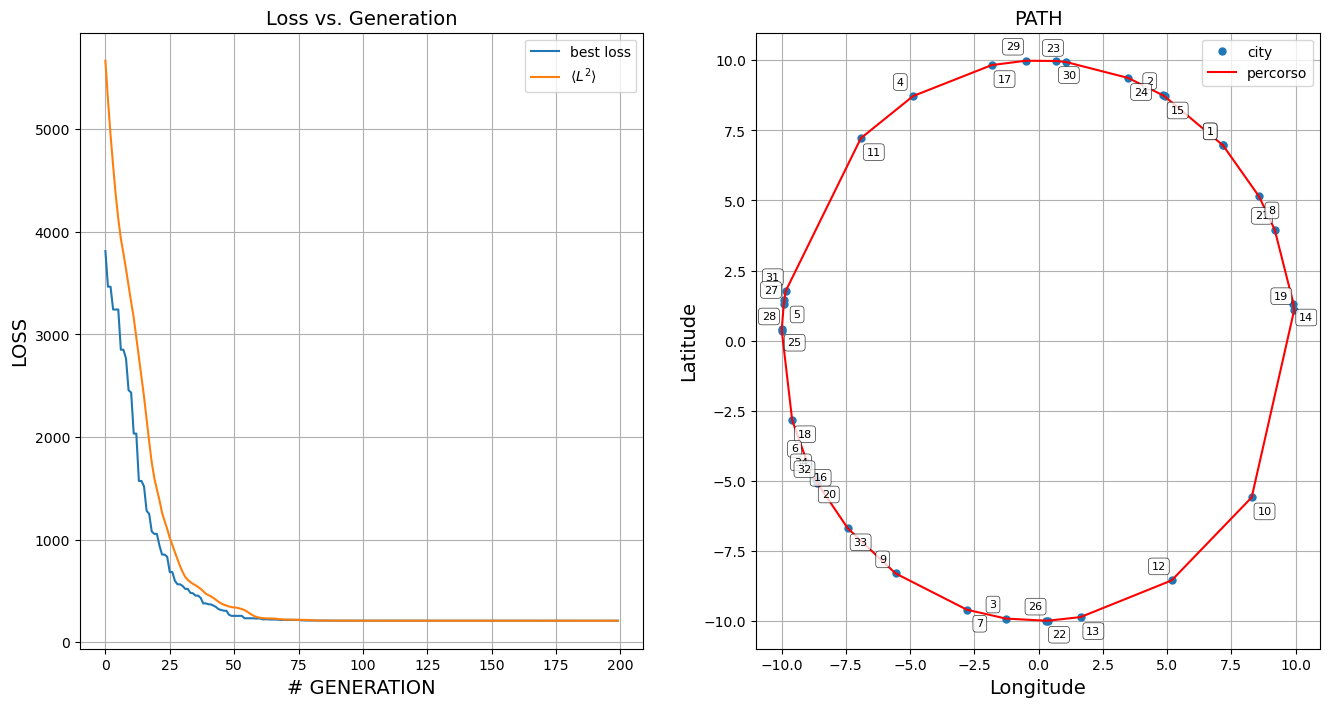

In [15]:
plot_('CIRCONFERENZA', 200)



**Figure 1.** On the left: convergence of the genetic algorithm on the circumference geometry. The blue curve represents the best loss found at each generation, while the orange curve shows the average loss of the best half of the population. On the right: optimal path obtained after 200 generations with 2000 chromosomes, where the cities are distributed on a circumference of radius 10.


The blue curve tracks the single best solution, the orange one indicates how the overall population is improving.  
Together, they show both the excellence of the best individual and the robustness of the population as a whole.  

The plot shows that the algorithm rapidly decreases the loss during the first generations and then stabilizes around the optimal solution.  
In the final configuration, the genetic algorithm correctly reconstructs the circular order of the cities, which is the expected optimal path in this geometry.  
This confirms that the implementation of selection, crossover, mutation, and elitism effectively drives the population towards the global optimum. 
 
The best path found is:
1	15 2 24 23 30	29	17	4	11	31	5	27	25	28	18	6	16	34	20	32	33	9	7	3	22	26	13	12	10	19	14	21	8

with a loss of $L^{2}=210.096$ .

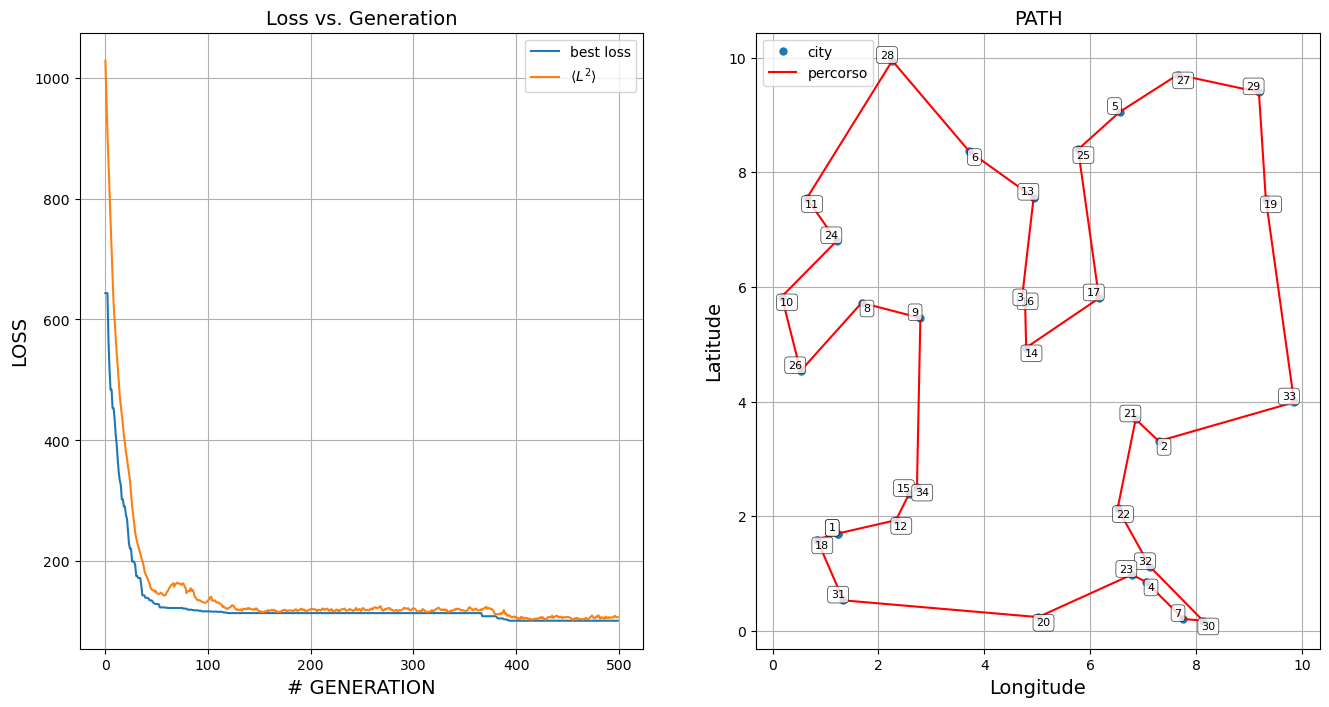

In [14]:
plot_('QUADRATO', 500)

**Figure 2.** On the left: convergence of the genetic algorithm on the square geometry. The blue curve shows the best loss per generation, while the orange curve represents the average loss of the best half of the population. On the right: optimal path obtained after 500 generations with 2000 chromosomes, where the cities are uniformly distributed inside a square of side 10.

In this case the problem is more complex than on the circumference, since there is no obvious optimal ordering of the cities.  
The loss decreases rapidly at first and then stabilizes with small oscillations, reflecting the difficulty of escaping local minima.  
The final path is non-trivial but does not present crossings, which is a strong indication that the genetic algorithm has reached an excellent approximation of the optimal solution.  


The best path found is:
1	12	15	34	9	8	26	10	24	11	28	6	13	16	3	14	17	25	5	27	29	19	33	2	21	22	32	30	7	4	23	20	31	18

with a loss of $L^{2}=101.858$ .